In [1]:
%pylab inline
style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Analysis of ``gapick`` tool genetic algorithm's (GA) run

Read more about PSF stars finding tool ``gapick`` in [astwro documentation](http://astwro.readthedocs.io/en/latest/gapick.html).

## Results directory

`gapick` wrotes several results into directory specified by ``--out_dir`` parameter. Set path to results dir below:

In [4]:
resultpath = '~/tmp/gapick_fine'

Checkout the content of this directory

In [5]:
import os
os.chdir(os.path.expanduser(resultpath))

In [6]:
!ls 

63d38b_NGC6871.fits gen013.gen          gen026.reg          gen040.lst
about.txt           gen013.lst          gen027.gen          gen040.reg
als.ap              gen013.reg          gen027.lst          gen041.gen
checkpoint.chk      gen014.gen          gen027.reg          gen041.lst
daophot.opt         gen014.lst          gen028.gen          gen041.reg
gen001.gen          gen014.reg          gen028.lst          gen042.gen
gen001.lst          gen015.gen          gen028.reg          gen042.lst
gen001.reg          gen015.lst          gen029.gen          gen042.reg
gen002.gen          gen015.reg          gen029.lst          gen043.gen
gen002.lst          gen016.gen          gen029.reg          gen043.lst
gen002.reg          gen016.lst          gen030.gen          gen043.reg
gen003.gen          gen016.reg          gen030.lst          gen044.gen
gen003.lst          gen017.gen          gen030.reg          gen044.lst
gen003.reg          gen017.lst          gen031.gen          gen044.reg
gen004

For each generation of GA there are three files:
* `genXXX.gen` - dump of all individuals as boolean matrix
* `genXXX.lst` - daophot LST file with PSF stars of best individual
* `genXXX.reg` - DS9 region file corresponding to LST file



Also, there are three links to most recent versions of that files:

In [7]:
!ls -l gen_last.*

lrwxr-xr-x  1 michal  staff  10 Jun 16 07:15 gen_last.gen -> gen049.gen
lrwxr-xr-x  1 michal  staff  10 Jun 16 07:15 gen_last.lst -> gen049.lst
lrwxr-xr-x  1 michal  staff  10 Jun 16 07:15 gen_last.reg -> gen049.reg


Such links are maintained during execution of `gapick` script which allows partial results analysis while script is running.

`*.gen` files structure is shown below:

In [8]:
!head gen_last.gen

111110000110100010000101100010010111001100111000110010011010011001110111100000011001011000101111
111110000110110011000101100010010111001100111000110010011010011001110111100000011001011000101111
111010000110110011000101100010010111001100111000110010011010011001110111110000011001011000101111
111110000110110011000101100010010111001100111000110010011010011001110111100000011001011000101111
111110000110110011000101100010010111001100111000110010011010011001110111100000011001011000101111
111010000110110011000101100010010111001101111000110010011010011001110111100000011001011000101111
111010000110110011000101100010010111001100111000110010011010011001110111100000011001011000101111
111110000010110011000101100010010111101100111000110010011010011001110011101000011011011100101111
111110000110110011000101100010010111001100111000110010011010011001110111100000011001011000101111
111110001110010011000101110010010111001100111000110010011010011001110111100000011001011001101110


Each line is one individual, each column is one candidate star. `1` means that candidate is a member of individual.

Moreover there is `about.txt` with information about parameters:

In [2]:
!cat about.txt

cat: about.txt: No such file or directory


Also several optput files of `daophot` commands are included, as well as `opt` files with used configuration.

## Evolution analysis

`logbook.pkl` file contains statistics collected by `deap` module during evolution.

In [10]:
import deap, pickle

In [11]:
f = open('logbook.pkl')
logbook = pickle.load(f)

Plot values of `chi`, and number of selected stars, against generation number 

In [12]:
gen = logbook.select('gen')
chi_mins = logbook.chapters["fitness"].select("min")
stars_avgs = logbook.chapters["size"].select("avg")

In [1]:
fig, ax1 = subplots()
fig.set_size_inches(10,6)
line1 = ax1.plot(gen, chi_mins, "b-", label="Minimum chi")
ax1.set_xlabel("Generation")
ax1.set_ylabel("chi", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, stars_avgs, "r-", label="Average stars number")
ax2.set_ylabel("stars", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

show()

NameError: name 'plt' is not defined

Spośród wszystkich gwiazd, algorytm wybrał 100 (domyślna wartość parametru `--stars_to_pick`) kandydatów przy pomocy polecenia `daophot PICK`. Następnie poleceniem `PSF` obliczył *point spread function* na postawie tego pełnego zbioru i uzyskał błędy dopasowania profilu dla tych gwiazd (`Profile errors ` zwracane przez `daophot PSF`). 

Z początkowej listy kandydatów odrzycił gwiazdy których błąd dopasowania profilu przekracza 0.1 (domyślna wartość parametru `--max_psf_err`). W tym przypadku pozostało 99 gwiazd.

W dalszej ewolucji jedynie spośród tych 99 gwiazd wybierane były gwiazdy do PSF.

Użytkownik, zamiast zdawać się na `PICK`, może również wskazać swoją listę początkowych kandydatów (paramter `--lst_file`).

Dla początkowych zbirów gwiazd *individuals* pierwszej generacji, wybierani byli kandydaci z prawdopodobieństwem 0.3 (domyślna wartość parametru `--ga_init_prob`) co dało średnio 30 gwiazd w zbiorze. *Average stars number* ma właśnie wartość około 30 dla zerowej generacji na wykresie. Później wartość ta ustabilizowała się w zakresie 45-50 gwiazd.

Wykres pokazuje też minimalizację parametru `chi` z generacji na generację, przy czym po 40 generacji spadek ten jest już bardzo nieznaczny.

Kolejny wykres pokazuje które gwiazdy były najczęściej wybierane w kolejnych generacjach. Kolor na przecięciu generacji i gwiazdy-kandydata wskazuje w jak wielu zbiorach danej generacji występowała gwiazda. 

In [14]:
spectrum = logbook.select('spectrum')
x_starno = range(len(spectrum[0]))

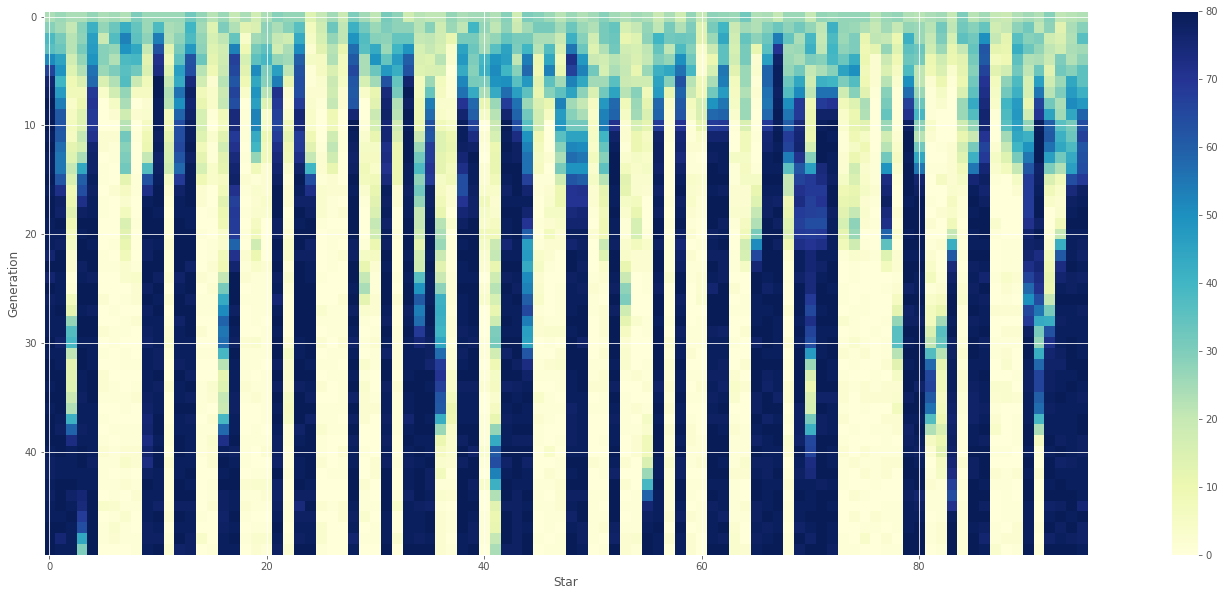

In [15]:
fig, ax1 = plt.subplots()
fig.set_size_inches(30,10)
#cont = ax1.contourf(x_starno, gen, spectrum)
cont = ax1.imshow(spectrum,  interpolation='nearest', cmap=plt.cm.YlGnBu)
ax1.set_xlabel("Star")
ax1.set_ylabel("Generation")
plt.colorbar(cont)

plt.show()
#plt.contourf(range(99), gen, spectrum)

Na wykresie widać jak w ciągu około 20 populacji wyłaniają się wyraźni liderzy. Niemniej również w późniejszych generacjach występują zmiany. Pomiędzy 70 a 80 generacją algorytm "wymienił" jedną z gwiazd na inną, ktora w poczatkowych generacjach nie była preferowana.

## Comaprision with other evolutions

#### Liczebność zbiorów pierwszej generacji 

Zgodnie z sugestią mojego promotora, dr. Gabrieli Michalskiej, przyjżałem się również jak przebiega ewolucja dla różnych ilości gwiazd w zbiorach wyjściowej generacji.

Parametr `--init_prob ` $x$ określa prawdopodobieństwo z jakim kandydat zostanie wylosowany do zbioru pierwszej generacji. Jeżeli, przykładowo skrypt wyznacza poleceniem `daophot PICK` 100 (wartość domyślna) kandydatów spośród których szukamy gwaizd do PSF, to początkowe zbiory miały średnio liczności $100 x$

Provide set of results dir and labels it below:

In [16]:
resultpaths = [
    '~/tmp/gapick_fine',
    '~/tmp/gapick_simple',
]
labels = [
    'fine',
    'simple',
]

Pobranie danych logów z wyników

In [18]:
logbook = []
resultpaths = [os.path.expanduser(p) for p in resultpaths]
for p in resultpaths:
    f = open(os.path.join(p,'logbook.pkl'))
    logbook.append(pickle.load(f))

gens = []
chi_min = []
stars_av = []
for l in logbook:
    gens.append(l.select('gen'))
    chi_min.append(l.chapters["fitness"].select("min"))
    stars_av.append(l.chapters["size"].select("avg"))

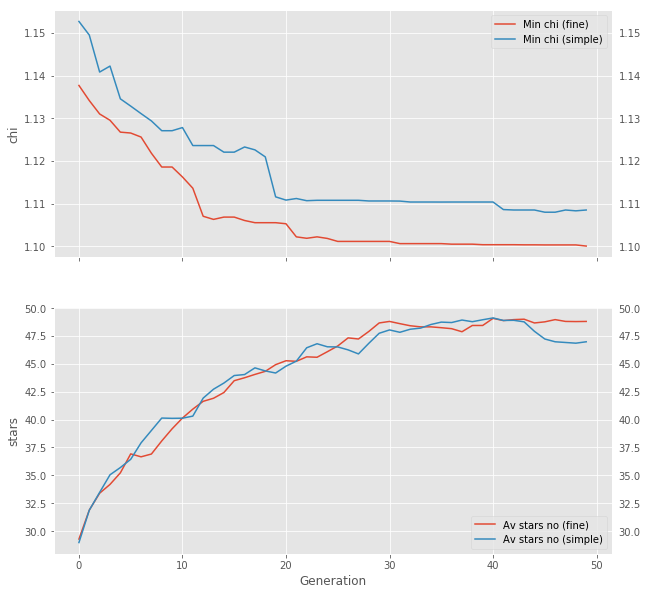

In [25]:
fig, ax = subplots(2, 1, sharex=True)
fig.set_size_inches(10,10)
for c, d, gen in zip(chi_min, labels, gens):
    ax[0].plot(gen, c, label="Min chi ({})".format(d))

ax[0].set_ylabel("chi")
ax[0].legend(loc="upper right")
ax[0].tick_params(axis='y', which='both', labelleft='on', labelright='on')

for s, d, gen in zip (stars_av, labels, gens):
    ax[1].plot(gen, s, label="Av stars no ({})".format(d))

ax[1].set_ylabel("stars")
ax[1].legend(loc="lower right")
ax[1].tick_params(axis='y', which='both', labelleft='on', labelright='on')
ax[1].set_xlabel("Generation")

show()

Sprawdźmy jak różne bądź podobne są skrajne rozwiązania, zestawiając "histogramy" ich przebiegu.

In [22]:
spectrum = [ l.select('spectrum') for l in logbook]
x_starno = range(len(spectrum[0][0]))

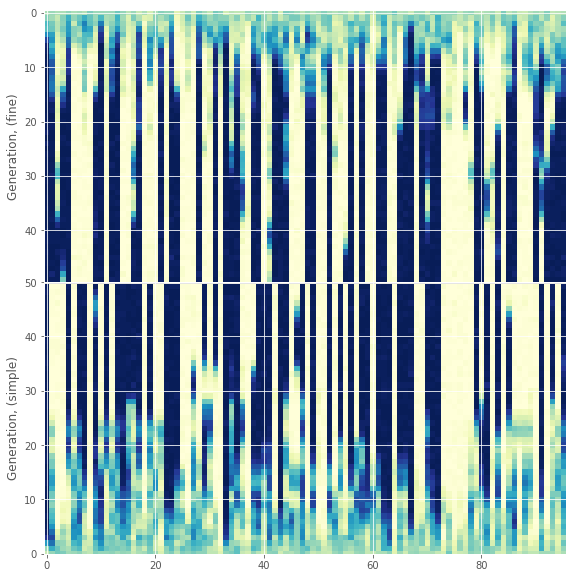

In [24]:
fig, ax = subplots(2,1)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10,10)
ax[1].set_ylim(0, len(gen))  # flip
ax[0].imshow(spectrum[0],  interpolation='nearest', cmap=plt.cm.YlGnBu)
ax[1].imshow(spectrum[-1],  interpolation='nearest', cmap=plt.cm.YlGnBu)
ax[0].set_xlabel("Star")
ax[0].set_ylabel("Generation, ({})".format(labels[0]))
ax[1].set_ylabel("Generation, ({})".format(labels[-1]))
#plt.colorbar(cont)

plt.show()

Widać, że wparawdzie część gwiazd występuje w wynikach obu ewolucji, generalnie ostateczny obraz jest wyraźnie różny.